In [1]:
using JLD
using PyPlot
using Statistics
using StatsBase 
using LinearAlgebra
using KernelDensity

In [2]:
using MultivariateStats
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Statistics
using StatsBase 
using Distributions

In [3]:
using JLD2
using FileIO
using BAT

In [5]:
function linreg(x, y; bias_c=true)
    
	X = Array{Float64}(undef, length(x),1)
	Y = Vector{Float64}(undef, length(y))
	X[1:length(x),1] .= x
	Y[1:length(y)] .= y
	sol = llsq(X, Y)
	coeff, bias = sol[1], sol[2]
    
    if bias_c == true
        g1(x) = bias + coeff*x 
        return g1, (coeff, bias)
    end
    
    if bias_c == false
        g2(x) = coeff*x
        return g2, (coeff, bias)
    end
    
end

linreg (generic function with 1 method)

In [6]:
data = load("../data/experiment/images.jld")

Dict{String,Any} with 5 entries:
  "ImagesIS2"   => [0 0 … 0 0; 0 0 … 0 0; … ; 43 33 … 35 15; 23 140 … 44 28]…
  "ImagesBTV50" => [10 3 … 0 0; 3 0 … 0 0; … ; 6 0 … 0 0; 4 0 … 0 0]…
  "charge"      => [0.1298, 0.1712, 0.095, 0.0433, 0.097, 0.136, 0.1404, 0.1837…
  "ImagesBTV26" => [81 24 … 14 0; 70 49 … 37 0; … ; 38 54 … 23 3; 69 22 … 23 4]…
  "ImagesBTV53" => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 21 0; 0 0 … 0 0]…

In [7]:
cam_1 = data["ImagesBTV50"]
cam_2 = data["ImagesBTV53"]
cam_3  = data["ImagesBTV26"]
cam_4 = data["ImagesIS2"]
charge  = data["charge"]

enumerate_events = collect(1:length(charge));

In [8]:
# Data Set 1

# cam_1_frame = (x=(160, 260), y=(140, 220))
# cam_2_frame = (x=(140, 240), y=(100, 200))
# cam_3_frame = (x=(200, 250), y=(140, 180))
# cam_4_frame = (x=(500, 850), y=(360, 600));

In [9]:
# Data Set 2: 

cam_1_frame = (x = (179, 249), y = (145, 215))
cam_2_frame = (x = (156, 226), y = (111, 181))
cam_3_frame = (x = (204, 244), y = (139, 179))
cam_4_frame = (x = (187, 257), y = (123, 193));

## MCMC Settings:

In [10]:
function log_lik(x,y)
    log_likelihood = let x = x, y = y
        params -> begin
            y_hat = params.a .+ params.b .* x
            p = sum(logpdf.(Normal.(y_hat, params.alpha), y))
            return LogDVal(p)
        end
    end
end

function get_uns(x, y)
    
    min_tmp = minimum(y)
    y_trans = y .- min_tmp
    max_tmp = maximum(y_trans)
    y_trans = y_trans ./ max_tmp
    
    posterior = PosteriorDensity(log_lik(x, y_trans), prior)
    samples = bat_sample(posterior, (10^5, 4), MetropolisHastings(),).result
    
    light_int = mean(samples)[1].b * max_tmp 
    light_std = std(samples)[1].b * max_tmp 
    
    return (light_int=light_int, light_std=light_std)
end
prior = NamedTupleDist( a =  -100.0 ..  100.0, b  = 0 .. 1, alpha= 0.0 .. 10.0 )
# posterior = PosteriorDensity(log_lik(charge_tmp, light_center_transformed), prior)
# samples = bat_sample(posterior, (10^5, 4), MetropolisHastings(),).result;

# 1. Measurements with Small Charge: 

In [11]:
event_mask = findall(x-> 5 < x < 15, charge);

### Cam-1:

In [12]:
data_temp = cam_1

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c1  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(32908.09311859194, 24816.33341487877), (32908.09311859194, 24816.33341487877))

In [13]:
@show "Light Intensity=", coeff_c1[1];

("Light Intensity=", coeff_c1[1]) = ("Light Intensity=", 32908.09311859194)


In [14]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 32917.7111967063)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 1181.9405756882663)


### Cam-2:

In [15]:
data_temp = cam_2

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c2  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(45718.90740715601, 9857.736273525165), (45718.90740715601, 9857.736273525165))

In [16]:
@show "Light Intensity=", coeff_c2[1];

("Light Intensity=", coeff_c2[1]) = ("Light Intensity=", 45718.90740715601)


In [17]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 45742.59138045693)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 1564.955525942637)


### Cam-3:

In [18]:
data_temp = cam_3

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c3  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(27751.912802224313, -546.4511626031856), (27751.912802224313, -546.4511626031856))

In [19]:
@show "Light Intensity=", coeff_c3[1];

("Light Intensity=", coeff_c3[1]) = ("Light Intensity=", 27751.912802224313)


In [20]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 27752.90756412129)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 1597.801565373618)


### Cam-4:

In [21]:
# reduce data step: 

img_tmp = zeros(Int64, 958, 320, 426)

for ind in 1:958, x in 1:320, y in 1:426
    img_tmp[ind, x, y] = round(Int64, mean(cam_4[ind, (x-1)*3+1:(x-1)*3+3,(y-1)*3+1:(y-1)*3+3] ))
end

cam_4 = deepcopy(img_tmp);

In [22]:
data_temp = cam_4

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c4  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(32034.895982716193, 7967.837424664055), (32034.895982716193, 7967.837424664055))

In [23]:
coeff_c1[1], coeff_c2[1], coeff_c3[1], coeff_c4[1]

(32908.09311859194, 45718.90740715601, 27751.912802224313, 32034.895982716193)

In [24]:
@show "Light Intensity=", coeff_c3[1];

("Light Intensity=", coeff_c3[1]) = ("Light Intensity=", 27751.912802224313)


In [25]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 32043.621358214412)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 575.6316274609215)


In [26]:
# FileIO.save("../data/experiment/dataset_2/m1/light_intensity.jld2", 
#     Dict("cam_1" => coeff_c1[1], 
#         "cam_2" => coeff_c2[1], 
#         "cam_3" => coeff_c3[1], 
#         "cam_4" => coeff_c4[1]))

# 2. Measurements with Large Charge: 

In [44]:
event_mask = findall(x-> x > 15, charge);

### Cam-1:

In [45]:
data_temp = cam_1

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_1_frame.y[1]:cam_1_frame.y[2],cam_1_frame.x[1]:cam_1_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end


# tmp_1 = minimum(light_center)
# light_center_transformed = light_center .- tmp_1
# tmp_2 = maximum(light_center_transformed)
# light_center_transformed = light_center_transformed ./ tmp_2

lin_int, coeff_c1  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(35147.44394156764, -23951.457878388548), (35147.44394156764, -23951.457878388548))

In [46]:
@show "Light Intensity=", coeff_c1[1];

("Light Intensity=", coeff_c1[1]) = ("Light Intensity=", 35147.44394156764)


In [30]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 35147.64886977112)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 1408.0950869294038)


### Cam-2:

In [47]:
data_temp = cam_2

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_2_frame.y[1]:cam_2_frame.y[2],cam_2_frame.x[1]:cam_2_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c2  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(50235.055295897284, -46280.570381109836), (50235.055295897284, -46280.570381109836))

In [48]:
@show "Light Intensity=", coeff_c2[1];

("Light Intensity=", coeff_c2[1]) = ("Light Intensity=", 50235.055295897284)


In [33]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 50219.15213034093)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 1611.9239947063904)


In [50]:
charge_tmp[2]

26.462099075317383

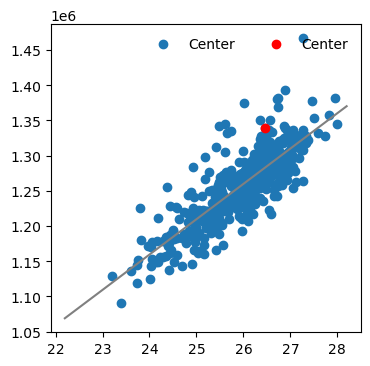

PyObject <matplotlib.legend.Legend object at 0x7feabbca6fa0>

In [51]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

ax.scatter(charge_tmp, light_center, label="Center")

ax.scatter(charge_tmp[2], light_center[2], color="red", label="Center")

xx = minimum(charge_tmp)-1:maximum(charge_tmp)+1
ax.plot(xx, lin_int.(xx), color="gray")

ax.legend(loc="upper right", ncol=3, framealpha=0.0)

### Cam-3:

In [35]:
data_temp = cam_3

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_3_frame.y[1]:cam_3_frame.y[2],cam_3_frame.x[1]:cam_3_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c3  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(10096.643089585976, 14416.584214083412), (10096.643089585976, 14416.584214083412))

In [36]:
@show "Light Intensity=", coeff_c3[1];

("Light Intensity=", coeff_c3[1]) = ("Light Intensity=", 10096.643089585976)


In [37]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 10102.747148510527)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 657.7783539111172)


### Cam-4:

In [38]:
# reduce data step: 

img_tmp = zeros(Int64, 958, 320, 426)

for ind in 1:958, x in 1:320, y in 1:426
    img_tmp[ind, x, y] = round(Int64, mean(cam_4[ind, (x-1)*3+1:(x-1)*3+3,(y-1)*3+1:(y-1)*3+3] ))
end

cam_4 = deepcopy(img_tmp);

LoadError: BoundsError: attempt to access 958×320×426 Array{Int64,3} at index [1, 1:3, 427:429]

In [39]:
data_temp = cam_4

pixel_mask = trues(size(data_temp[1,:,:]))
pixel_mask[1:50,:] .= false
pixel_mask[end-50:end,:] .= false
pixel_mask[:,1:50] .= false
pixel_mask[:,end-50:end] .= false
pixel_mask[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= false

pixel_mask_2 = falses(size(data_temp[1,:,:]))
pixel_mask_2[cam_4_frame.y[1]:cam_4_frame.y[2],cam_4_frame.x[1]:cam_4_frame.x[2]] .= true

charge_tmp = []
light_center = []

for ind in event_mask
    ch = charge[ind]
    lp = mean(data_temp[ind,:,:][pixel_mask])
    lc = sum(data_temp[ind,:,:][pixel_mask_2]) - sum(pixel_mask_2)*lp
    
    push!(charge_tmp, ch)
    push!(light_center, lc)
end

lin_int, coeff_c4  = linreg(charge_tmp, light_center)

(var"#g1#2"{Float64,Float64}(33406.896659621576, 55027.265357188306), (33406.896659621576, 55027.265357188306))

In [40]:
coeff_c1[1], coeff_c2[1], coeff_c3[1], coeff_c4[1]

(35147.44394156764, 50235.055295897284, 10096.643089585976, 33406.896659621576)

In [41]:
@show "Light Intensity=", coeff_c4[1];

("Light Intensity=", coeff_c4[1]) = ("Light Intensity=", 33406.896659621576)


In [42]:
tmp_uns = get_uns(charge_tmp, light_center)

@show "Light Intensity=", tmp_uns.light_int;
@show "Light Uns=", tmp_uns.light_std;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

("Light Intensity=", tmp_uns.light_int) = ("Light Intensity=", 33405.863821185034)
("Light Uns=", tmp_uns.light_std) = ("Light Uns=", 517.6687961255278)


In [43]:
# FileIO.save("../data/experiment/dataset_2/m2/light_intensity.jld2", 
#     Dict("cam_1" => coeff_c1[1], 
#         "cam_2" => coeff_c2[1], 
#         "cam_3" => coeff_c3[1], 
#         "cam_4" => coeff_c4[1]))